In [1]:
import xarray as xr

In [2]:
from matplotlib import pyplot as plt

In [3]:
from dask.distributed import Client

In [4]:
from access_nri_intake.experiment import use_datastore
from access_nri_intake.source import builders
from intake import open_esm_datastore


In [5]:
EXPERIMENTS = {
    "25km-1.0-beta": [
        "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/"
    ],  # (our name: run name(s))
    "2025.08.000": [
        "/g/data/tm70/as2285/payu/632/632-dev-MC_25km_jra_ryf/archive/"# (our name: run name(s))
    ]
}


In [6]:
esmds = dict()
for iExp in EXPERIMENTS:
    esmds[iExp] = [open_esm_datastore(
            iPath+"experiment_datastore.json",
            columns_with_iterables=[
                "variable",
                "variable_long_name",
                "variable_standard_name",
                "variable_cell_methods",
                "variable_units"
            ]
        )     for i,iPath in enumerate(EXPERIMENTS[iExp])
    ]
    

In [7]:
esmds['25km-1.0-beta'][0].search(realm='ocean', file_id='access_om3_mom6_scalar_1day_snap_XXXX', start_date="1900-.*").df

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/core.py:432: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})


,filename,file_id,path,filename_timestamp,frequency,start_date,end_date,variable,variable_long_name,variable_standard_name,variable_cell_methods,variable_units,realm
0,access-om3.mom6.scalar.1day.snap.1900.nc,access_om3_mom6_scalar_1day_snap_XXXX,/g/data/ol01/access-om3-output/access-om3-025/...,1900,1day,"1900-01-01, 12:00:00","1901-01-01, 12:00:00","[scalar_axis, time, soga, thetaoga, tosga, sos...","[none, time, Global Mean Ocean Salinity, Globa...","[, , sea_water_salinity, sea_water_potential_t...","[, , time: point, time: point, time: point, ti...","[, days since 1900-01-01 00:00:00, psu, degC, ...",ocean


In [8]:
client = Client(threads_per_worker = 1)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:173: ResourceWarning: unclosed <socket.socket fd=58, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46329 instead
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [9]:
client.dashboard_link

'/proxy/46329/status'

In [10]:
mom_scalar_ds = dict()
for iExp in EXPERIMENTS:
   mom_scalar_ds[iExp] = xr.concat([
        ds.search(realm='ocean', file_id='access_om3_mom6_scalar_1day_snap_XXXX', start_date="1900-.*").to_dask() for ds in esmds[iExp]
        ],dim="time"
   )

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/core.py:432: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/core.py:432: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})


plot all the scalar vars for all the experiments

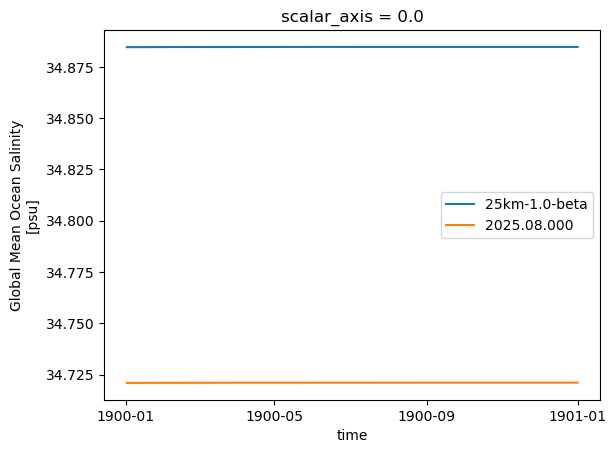

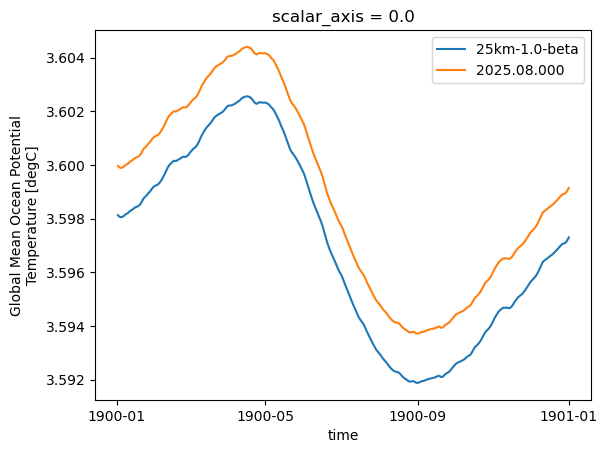

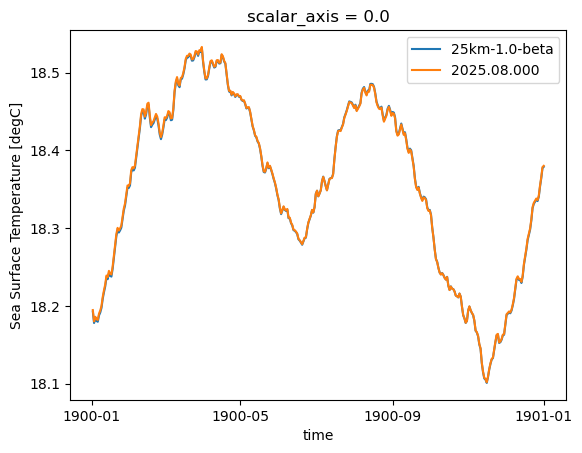

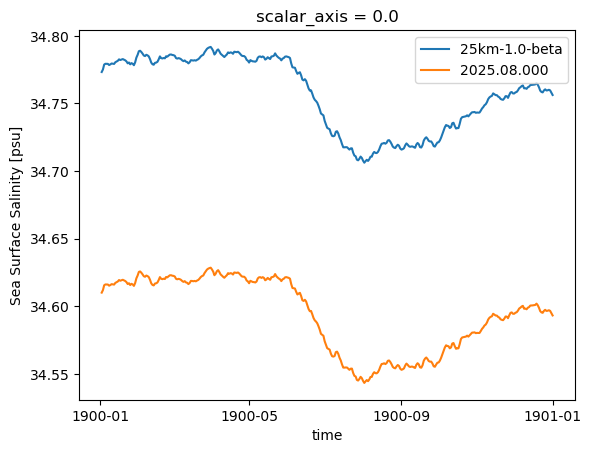

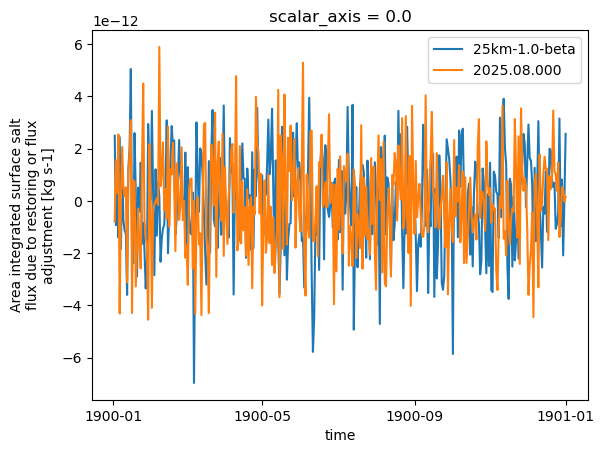

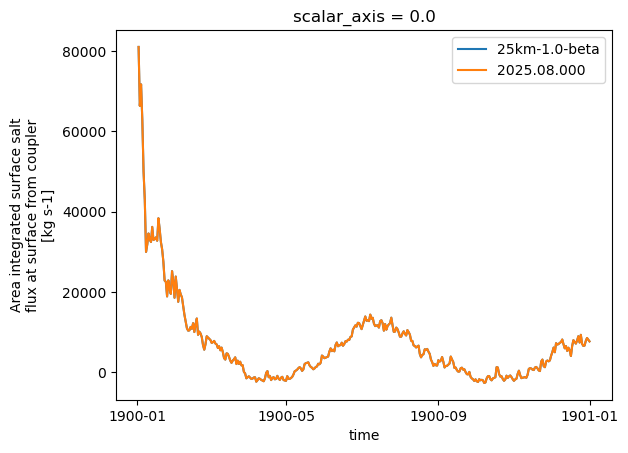

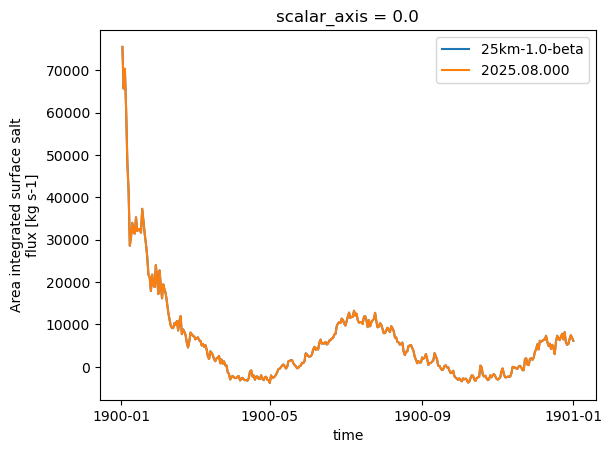

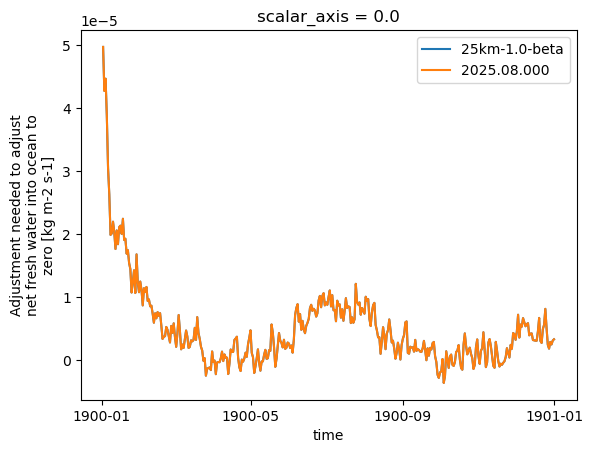

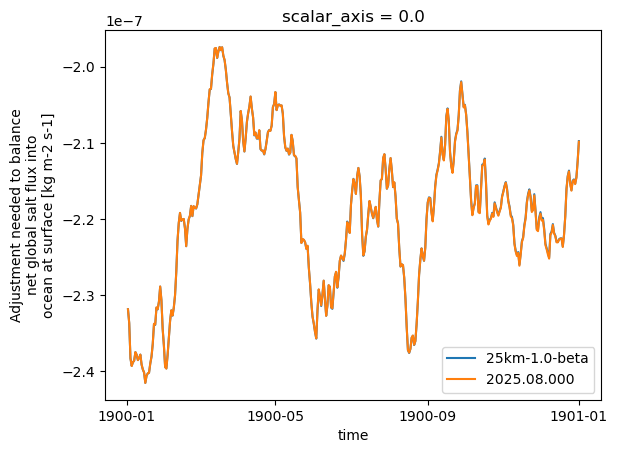

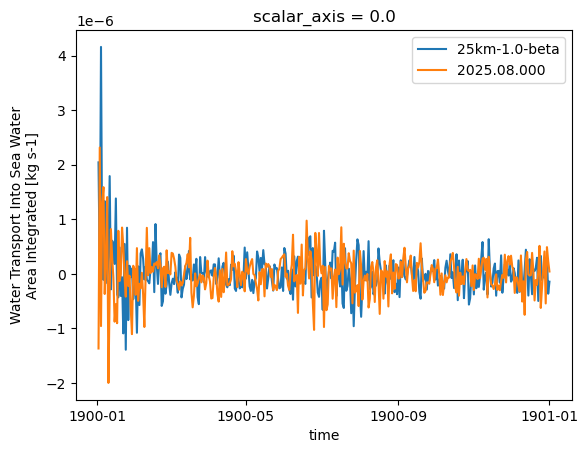

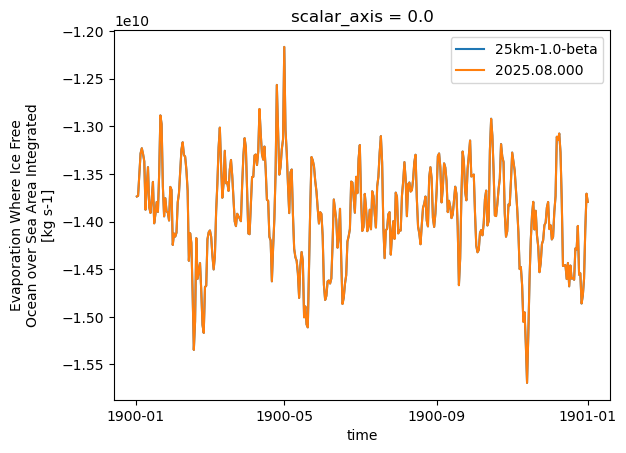

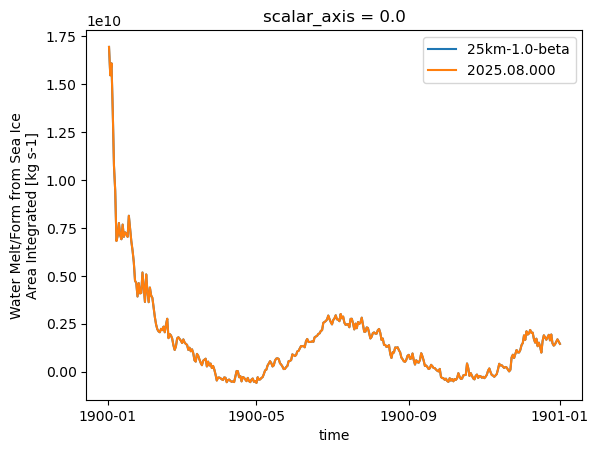

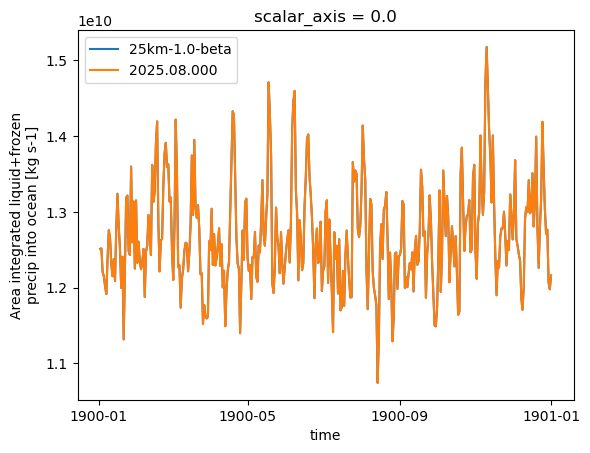

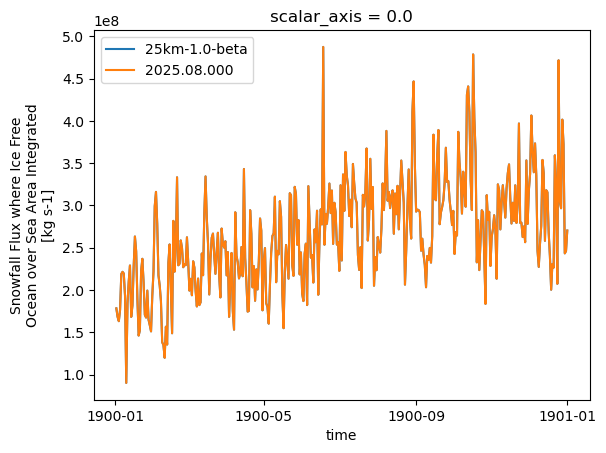

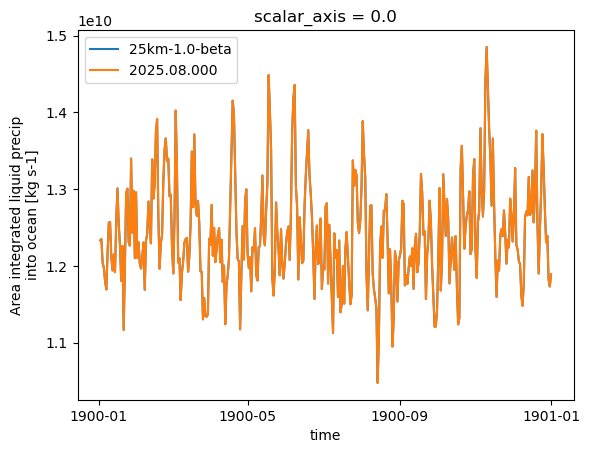

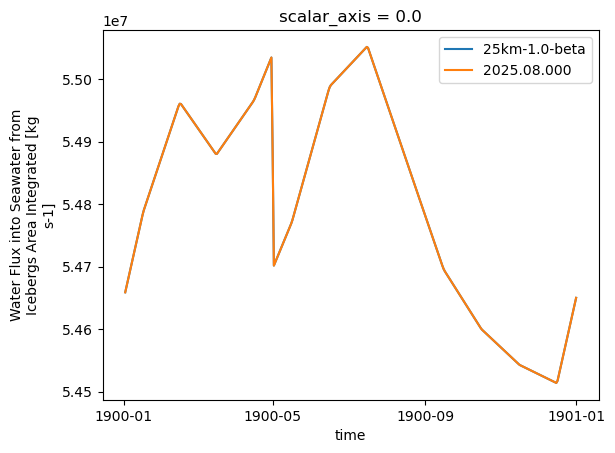

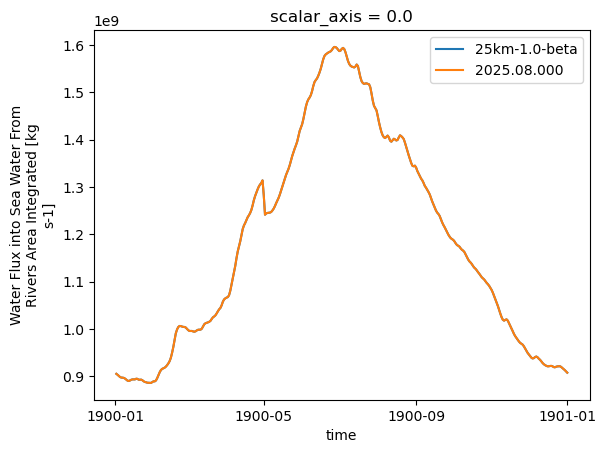

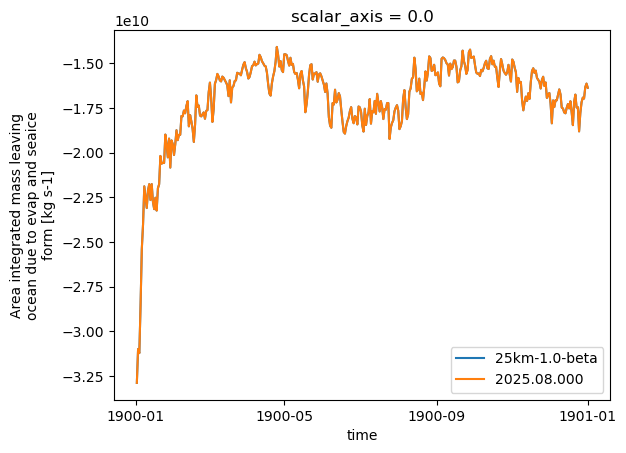

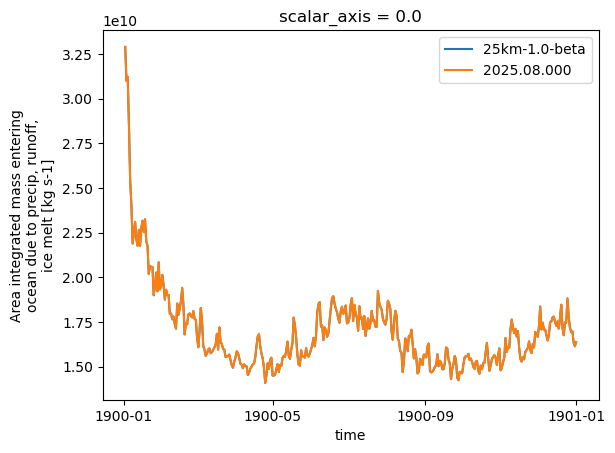

In [11]:
for iVar in mom_scalar_ds[list(EXPERIMENTS.keys())[0]].data_vars: #this is slightly lazy, we should intersect all the experiments to find the minimum subset of common scalar vars
    for iExp in EXPERIMENTS:
        mom_scalar_ds[iExp][iVar].plot(label=iExp)
    plt.legend()
    plt.show()

In [12]:
client.close()